sghHDFGDFS start
activity:  start ['A', 'B'] [] 0 0 0 0
activity:  A ['C', 'D'] ['start'] 0 3 0 3
activity:  B ['G'] ['start'] 0 5 4 9
activity:  C ['I'] ['A'] 3 9 3 9
activity:  D ['E', 'F'] ['A'] 3 5 8 10
activity:  E ['J'] ['D'] 5 8 10 13
activity:  F ['H'] ['D'] 5 8 10 13
activity:  G ['H'] ['B'] 5 9 9 13
activity:  H ['finish'] ['F', 'G'] 9 14 13 18
activity:  I ['J'] ['C'] 9 13 9 13
activity:  J ['K'] ['I', 'E'] 13 15 13 15
activity:  K ['finish'] ['J'] 15 18 15 18
activity:  finish [] ['H', 'K'] 18 18 18 18
critical Path:  ['start', 'A', 'C', 'I', 'J', 'K', 'finish']
critical_activities:  ['A', 'C', 'I', 'J', 'K']
finish  18
Resource List [5, 5, 5, 9, 9, 9, 9, 9, 6, 5, 5, 5, 5, 6, 4, 5, 5, 5]
Cumulative R: [5, 10, 15, 24, 33, 42, 51, 60, 66, 71, 76, 81, 86, 92, 96, 101, 106, 111]
cumulative R^2:  [25, 50, 75, 156, 237, 318, 399, 480, 516, 541, 566, 591, 616, 652, 668, 693, 718, 743]
activity_index_map:  {'A': 0, 'C': 1, 'I': 2, 'J': 3, 'K': 4, 'B': 5, 'G': 6, 'H': 7, 'D': 8, 'E'

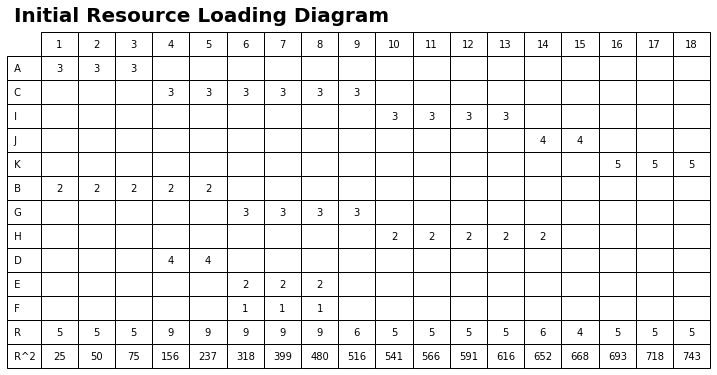

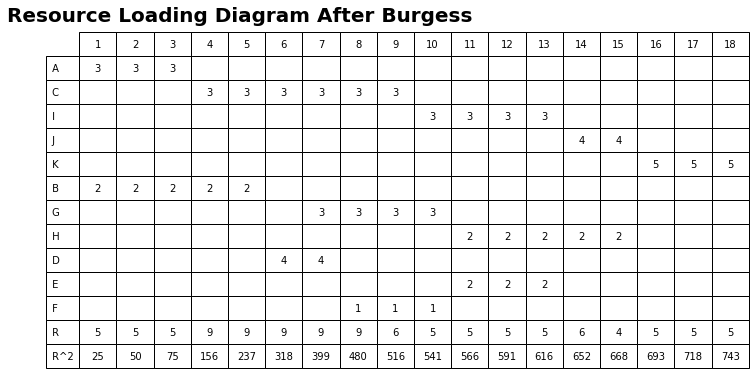

In [44]:
########## activity class ##################
import copy
import matplotlib.pyplot as plt

class Activity:
    def __init__(self, name, duration, resource, es, ef, ls, lf, freefloat, pred, sucs):
        self.name = name
        self.duration= int(duration)
        self.resource= int(resource)
        self.es=es
        self.ef=ef
        self.ls=ls
        self.lf=lf
        self.freefloat=freefloat
        self.pred=pred
        self.sucs=sucs

class inputProcessing:
    def __init__(self):
        super(inputProcessing, self).__init__()
        # self.arg = arg
        global start_activities
        global all_activity
        global filename

    def takeinput(self):
        filename="data.txt"
        start_activities=[] #activities who don't have any predecessors
        all_activity=[] #list of all activity objects
        with open(filename) as f:
            activity_list = f.readlines()
        activity_list = [x.strip() for x in activity_list] 
        # print(activity_list)

        cnt=0
        for activity in activity_list:
            x=activity.split(",")
            # print(x)
            pred=[]
            sucs=[]
            ### assuming first column is name, last twos are resource and duration,, al others are dependency list
            for i in range(1,len(x)-2):
                # print(x[i])
                if x[i]=="-":
                    cnt+=1
                    start_activities.append(x[0])
                pred.append(x[i])

            #name, duration, resource, es, ef, ls, lf, freefloat, pred, sucs
            ac1=Activity(x[0],x[len(x)-2],x[len(x)-1],-1,-1,9874217,9874217,-1,pred,sucs)
            all_activity.append(ac1)
        ## if there are more than 1 start nodes, make a start node on your own
        if cnt>1:
            all_activity=inputProcessing().create_start_node(start_activities, all_activity)
        else:
            all_activity=inputProcessing().rename_start_node(start_activities, all_activity)

        # print(all_activity[0].name)
        all_activity=self.forward_pass(all_activity)
        #print("after fp ", all_activity)
        all_activity=self.backward_pass(all_activity)
        #print(all_activity)
        critical_path = self.get_critical_path(all_activity)
            
        critical_activities=[]
        for i in range(1,len(critical_path)-1):
            critical_activities.append(critical_path[i])
        
        print("critical_activities: ", critical_activities)
            
        resource_list=self.calculate_resource(all_activity)
        cumulative_r=self.calculate_cumulative_R(all_activity,resource_list)
        cumulative_r_2=self.calculate_cumulative_R_2(all_activity,resource_list)
        non_critical_activities=self.get_non_critical_activities(all_activity)
        
        #name, duration, resource, es, ef, ls, lf, freefloat, pred, sucs
        #print("All activities: ")
        #for activity in all_activity:
            #print(activity.name, activity.duration,activity.resource, activity.es, activity.ef, activity.ls, activity.lf, activity.freefloat, activity.pred, activity.sucs )
        
        #print("Non-critical activities: ")
        #for activity in non_critical_activities:
            #print(activity)
        
        self.create_diagram(non_critical_activities, all_activity, resource_list, cumulative_r, cumulative_r_2, critical_path)
        #self.burgess(non_critical_activities, all_activity, resource_list, cumulative_r_2, critical_path)

        
        
        
        
    def burgess(self, non_critical_activities, all_activity, resource_list, cumulative_r_2, critical_path):
        node_move={}
        i = len(non_critical_activities)-1
        
        res_len=len(resource_list)
        temp_resource_list = [0]* res_len
        for j in range(0,len(temp_resource_list)):
            temp_resource_list[j] = resource_list[j]
       
        visited=[]
        queue=[]
        graph={}
        
        for activity in all_activity:
            if activity in non_critical_activities:
                graph[activity.name]=activity.pred
                
        print("graph",graph)
        
        sorted_non_critical_activities = [0]*len(non_critical_activities)
        i = len(non_critical_activities)-1
        for j in range(0,len(sorted_non_critical_activities)):
            sorted_non_critical_activities[j] = non_critical_activities[i]
            i=i-1
        
        i = len(non_critical_activities)-1
        #self.burgess_bfs(visited, queue, graph, non_critical_activities[i], all_activity, node_move, temp_resource_list, cumulative_r_2,critical_path)
        self.burgess_all(sorted_non_critical_activities, all_activity, node_move, temp_resource_list,critical_path)

    def burgess_all(self, sorted_non_critical_activities, all_activity, node_move, temp_resource_list, critical_path):
        
        for main_node in sorted_non_critical_activities:
            node_move[main_node.name]=0
            
        for main_node in sorted_non_critical_activities:
            
            for i in range(main_node.es,main_node.es+main_node.freefloat):
                    print("Sorted: ",main_node.name, main_node.freefloat, i)
                    temp_resource_list[i-1]=temp_resource_list[i-1]-main_node.resource
                    temp_resource_list[i]=temp_resource_list[i]+main_node.resource
                    temp_cumulative_r_2 = self.calculate_cumulative_R_2(all_activity, temp_resource_list)
                
                    
                    if i==main_node.es:
                        cumulative_r_2 = copy.deepcopy(temp_cumulative_r_2)
                        a=i+1-main_node.es
                        node_move[main_node.name]=node_move[main_node.name]+a
                    
                    len_temp=len(temp_cumulative_r_2)
                    len_cumu=len(cumulative_r_2)
                    
                    
                    #print("temp_cumulative_r_2 for ",main_node.name," ",temp_cumulative_r_2)
                    
                    if i!=main_node.es:
                        #print("cumulative_r_2 for ",main_node.name," ",cumulative_r_2)
                        #print("temp_cumulative_r_2 for ",main_node.name," ",temp_cumulative_r_2)
                        #print("node move for ",main_node.name," ",node_move)
                        if temp_cumulative_r_2[len_temp-1] < cumulative_r_2[len_cumu-1]:
                            cumulative_r_2 = copy.deepcopy(temp_cumulative_r_2)
                            node_move[main_node.name]+=i+1-main_node.es
                            #print("after if cumulative_r_2 for ",main_node.name," ",cumulative_r_2)
                            #print("node move for ",main_node.name," ",node_move)
            #print("Delay activity ",main_node.name," move")
            
            print("cumulative_r_2:",cumulative_r_2, "\nnode_move: ",node_move,"\ntemp_resource_list: ",temp_resource_list)

        
        
        
        
    def burgess_bfs(self, visited, queue, graph, main_node, all_activity, node_move, temp_resource_list, cumulative_r_2, critical_path):
        visited.append(main_node.name)
        queue.append(main_node.name)
        
        while queue:
            s = queue.pop(0) 
            print ("Serial of S:",s, end = " ") 
            #popped s er jonno ef,ef+ff loop chalay r^2 ber korbo min ta
 
            for neighbour in graph[s]:
                if neighbour not in critical_path:
                  if neighbour not in visited:
                    visited.append(neighbour)
                    queue.append(neighbour)
    
    

                    
            
        

    
    def get_non_critical_activities(self, all_activity):
        non_critical_activities=[]
        for activity in all_activity:
            if activity.freefloat!=0:
                non_critical_activities.append(activity)
            
        #print("non-critical: ",activity.name)
        return non_critical_activities
        
        

    def rename_start_node(self, start_activities, all_activity):
        sucs_list=[]
        all_activity=self.get_successor_list(all_activity)
        for activity in all_activity:
            if activity.name==start_activities[0]:
                activity.name="start"
                activity.es=0
                activity.ef=activity.es+activity.duration
                sucs_list=activity.sucs
        #print("sucs ", sucs_list)
        for activity in all_activity:
            if activity.name in sucs_list:
                activity.pred=["start"]

        return all_activity


    def create_start_node(self, start_activities, all_activity):
        pred=[]
        sucs=start_activities
        ac1=Activity("start",0,0,0,0,0,0,0,pred,sucs)
        # all_activity.append(ac1)
        all_activity.insert(0,ac1)
        ## inserting start node at the 0 position
        # print(all_activity[0].sucs)
        return all_activity

    def create_finish_node(self, finish_activities, all_activity):
        pred=finish_activities
        sucs=[]
        ac1=Activity("finish",0,0,-1,-1,-1,-1,-1,finish_activities,sucs)
        all_activity.append(ac1)
        
        return all_activity

    def bfs_forward_pass(self,visited,queue, graph, node, all_activity):
        visited.append(node)
        queue.append(node)
        # print(graph)
        ## dictionary for mapping the activity names with the activity objects easily
        activity_dict={}
        for activity in all_activity:
            activity_dict[activity.name]=activity
            # print(activity.name)


        while queue:
            s = queue.pop(0) 
            # print ("lol ",s, end = " ") 
            # print(graph)
            for neighbour in graph[s]:
                #### visiting each neighbour and calculating ES and EF
                activity_dict[neighbour].es=max(activity_dict[s].ef,activity_dict[neighbour].es)
                activity_dict[neighbour].ef=activity_dict[neighbour].es+activity_dict[neighbour].duration
                # print("neighbour ",neighbour, activity_dict[neighbour].es)
                if neighbour not in visited:
                    visited.append(neighbour)
                    queue.append(neighbour)
        #### we were keeping values in the dict before, nnow keepingthis in the main list
        for activity in all_activity:
            activity.es=activity_dict[activity.name].es
            activity.ef=activity_dict[activity.name].ef
        # print(all_activity)

        return all_activity

    def bfs_backward_pass(self,visited,queue, graph, node, all_activity):
        visited.append(node)
        queue.append(node)
        # print(graph)
        ## dictionary for mapping the activity names with the activity objects easily
        activity_dict={}
        for activity in all_activity:
            activity_dict[activity.name]=activity
            # print(activity.name)


        while queue:
            s = queue.pop(0) 
            #print ("lol ",s, end = " ") 
            # print(graph)
            for neighbour in graph[s]:
                if neighbour!="-":
                    #### visiting each neighbour and calculating LS and LF
                    ############ parallel path gular level equivalent na hole jhamela---------
                    activity_dict[neighbour].lf=min(activity_dict[s].ls,activity_dict[neighbour].lf)
                    activity_dict[neighbour].ls=activity_dict[neighbour].lf-activity_dict[neighbour].duration
                    # print("neighbour ",neighbour, activity_dict[neighbour].lf)
                    if neighbour not in visited:
                        visited.append(neighbour)
                        queue.append(neighbour)
        #### we were keeping values in the dict before, nnow keepingthis in the main list
        for activity in all_activity:
            activity.ls=activity_dict[activity.name].ls
            activity.lf=activity_dict[activity.name].lf
        # return all_activity
        print("sghHDFGDFS",all_activity[0].name)

        return all_activity
    def get_successor_list(self, all_activity):
        pred_dict={}
        for activity in all_activity:
            pred_dict[activity.name]=activity.pred

        for activity in all_activity:
            sucs_list=[]
            for key in pred_dict:
                # print(pred_dict[key])
                if activity.name in pred_dict[key]:
                    sucs_list.append(key)
                    # sucs_dict[activity.name]=key
            # sucs_dict[activity.name]=sucs_list
            activity.sucs=sucs_list
        return all_activity
    def forward_pass(self,all_activity):
        # all_activity
        ############ mapping activities with predecessors#####################
        pred_dict={}
        for activity in all_activity:
            pred_dict[activity.name]=activity.pred


        start_sucs=[] #keeps the valaues  of the successors of start node

        ##### inserting start as start node of the nodes, who do not have any predecessors
        for key in pred_dict:
            if pred_dict[key]==['-'] and key!="start":
                # print("key ", key, pred_dict[key])
                pred_dict[key]="start"
                start_sucs.append(key)
        for activity in all_activity:
            if activity.name=="start":
                activity.sucs=start_sucs
        for activity in all_activity:
            for val in start_sucs:
                if activity.name==val:
                    activity.pred=['start']

        sucs_dict={}### mapping each node with it's successors list
        cnt=0
        finish_activities=[]### the activities who do nont have any successors

        ##### checking if a key is in the predecessors list of a node, if true,   
        ######### the key is the successor of the predecessors
        for activity in all_activity:
            sucs_list=[]
            for key in pred_dict:
                # print(pred_dict[key])
                if activity.name in pred_dict[key]:
                    sucs_list.append(key)
                    # sucs_dict[activity.name]=key
            sucs_dict[activity.name]=sucs_list
            activity.sucs=sucs_list
            if sucs_list==[] and activity.name!="start":
                cnt+=1
                finish_activities.append(activity.name)
        if cnt>1:
            ### if thereis morethan one finish node, then create a finish node
            all_activity=inputProcessing().create_finish_node(finish_activities,all_activity)
        
        # print(all_activity[len(all_activity)-1].pred)


        visited = [] # List to keep track of visited nodes.
        queue = []     #Initialize a queue
        ############# calling cfs with start node###############
        all_activity=inputProcessing().bfs_forward_pass(visited, queue, sucs_dict, 'start', all_activity)



        ### putting the activities who do not have any successor, as successor of finish activities
        all_activity[len(all_activity)-1].pred=finish_activities 
        for activity in all_activity:
            for val in finish_activities:
                if activity.name==val:
                    activity.sucs=['finish']
                    ### calculating value of finish nodes
                    all_activity[len(all_activity)-1].es=max(all_activity[len(all_activity)-1].es,activity.ef)
                    all_activity[len(all_activity)-1].ef=all_activity[len(all_activity)-1].es


        ################ printing all the activities#####################
        # for activity in all_activity:
        # 	print("activity ", activity.name, activity.sucs, activity.pred, activity.es, activity.ef)
        return all_activity
    def backward_pass(self, all_activity):
        pred_dict={}
        for activity in all_activity:
            pred_dict[activity.name]=activity.pred
            if activity.name=="finish":
                activity.lf=activity.ef
                activity.ls=activity.lf
        #print(pred_dict)
        visited = [] # List to keep track of visited nodes.
        queue = []     #Initialize a queue

        ############# calling bfs with start node###############
        all_activity=inputProcessing().bfs_backward_pass(visited, queue, pred_dict, 'finish', all_activity)

        ################ printing all the activities#####################
        for activity in all_activity:
            print("activity: ", activity.name, activity.sucs, activity.pred, activity.es, activity.ef,  activity.ls,  activity.lf)

        #print(all_activity[0].name)
        return all_activity

    def get_critical_path(self, all_activity):
        critical_path=[]
        #print(all_activity)
        for activity in all_activity:
            if activity.ls-activity.es==0:
                activity.freefloat=0
                critical_path.append(activity.name)
            else:
                min_es_of_successor=self.get_min_es_of_successor(all_activity, activity)
                activity.freefloat= min_es_of_successor-activity.ef

        print("critical Path: ",critical_path)
        return critical_path
    
    def get_min_es_of_successor(self, all_activity, activity):
        temp_es=99999
        for pr in activity.sucs:
            #print("Pr: ",pr)
            for ac in all_activity:
                if ac.name==pr:
                    if ac.es<temp_es:
                        temp_es=ac.es
                
        return temp_es

    def calculate_resource(self,all_activity):
        n=all_activity[len(all_activity)-1].lf
        print("finish ",n)
        resource_list=[0]*n
        i=0
        for activity in all_activity:
            #print(activity.resource)
            for x in range(activity.es, activity.ef):
                resource_list[x]=resource_list[x]+activity.resource
            
        print("Resource List",resource_list)
        return resource_list
    def calculate_cumulative_R(self,all_activity, resource_list):
        n=all_activity[len(all_activity)-1].lf
        cumulative_r=[0]*n
        cumulative_r[0]=resource_list[0]
        i=1
        for res in range(1,len(resource_list)):
            cumulative_r[i]=cumulative_r[i-1]+resource_list[res]
            i+=1

        print("Cumulative R:", cumulative_r)

        return cumulative_r
    def calculate_cumulative_R_2(self,all_activity, resource_list):
        n=all_activity[len(all_activity)-1].lf
        cumulative_r_2=[0]*n
        cumulative_r_2[0]=resource_list[0]**2
        i=1
        for res in range(1,len(resource_list)):
            cumulative_r_2[i]=cumulative_r_2[i-1]+resource_list[res]**2
            i+=1

        print("cumulative R^2: ",cumulative_r_2)
        return cumulative_r_2
    
    def create_diagram(self, non_critical_activities, all_activity, resource_list, cumulative_r, cumulative_r_2, critical_path):
        #print("non_critical_activities, all_activity, resource_list, cumulative_r, cumulative_r_2, critical_path")
        #print(non_critical_activities, all_activity, resource_list, cumulative_r, cumulative_r_2, critical_path)
        val1=[]
        val2=["A","C","I","J","K","B","G","H","D","E","F","R","R^2"]
        row_header=[]
        for i in range(0,len(val2)):
            row_header.append(" "+val2[i]+" ")
            
        for i in range(1,19):
            val1.append(i)
        val3 = [["" for c in range(1,19)] for r in range(1,14)]

        rowColours=[]
        colColours=[]
        cellColours=[]

        activity_index_map={}
        for i in range (0,len(val2)):
            activity_index_map[val2[i]]=i

        print("activity_index_map: ", activity_index_map)

        rows, cols = (13, 18) 
        #table = [[0]*cols]*rows
        table = [["" for c in range(0,cols)] for r in range(0,rows)]
        
        for r in range (0,rows-2):
            for key in activity_index_map:
                if activity_index_map[key]==r:
                    activity_name=key
            for activity in all_activity:
                if activity.name==activity_name:
                    current_resource=activity.resource
                    current_es=activity.es
                    current_ef=activity.ef
            
            for c in range (0,cols):
                if c>=current_es and c<current_ef:#if c is between es and ef range
                    table[r][c]= current_resource #
                    val3[r][c]= current_resource #resource
        
        for c in range (0,cols):
            table[r+1][c]= resource_list[c]
            val3[r+1][c]= resource_list[c]
            table[r+2][c]= cumulative_r_2[c]
            val3[r+2][c]= cumulative_r_2[c]

        #print(table)
        colWidths=[]
        for i in range(0,cols):
            colWidths.append((1/cols)*2)
        
        fig, ax = plt.subplots() 
        ax.set_axis_off() 
        table = ax.table( 
            cellText = val3,  
            rowLabels = row_header,  
            colLabels = val1, 
            rowColours =["white"] * rows,  
            colColours =["white"] * cols, 
            colWidths = colWidths,
            cellLoc ='center',  
            loc ='upper left')         
   
        table.set_fontsize(10)
        table.scale(1, 2)
        
        ax.set_title('Initial Resource Loading Diagram', 
             fontweight ="bold", fontsize=20) 
   
        plt.show()
    
        delay_map={
            'A':0,
            'C':0,
            'I':0,
            'J':0,
            'K':0,
            'H': 1,
            'G': 1,
            'F': 2,
            'E': 5,
            'D': 2,
            'B':0
        }
        val3 = [["" for c in range(1,19)] for r in range(1,14)]
        table2 = [["" for c in range(0,cols)] for r in range(0,rows)]
        
        for r in range (0,rows-2):
            for key in activity_index_map:
                if activity_index_map[key]==r:
                    activity_name=key
            for activity in all_activity:
                if activity.name==activity_name:
                    current_resource=activity.resource
                    current_es=activity.es+delay_map[activity_name]
                    current_ef=activity.ef+delay_map[activity_name]
            
            for c in range (0,cols):
                if c>=current_es and c<current_ef:#if c is between es and ef range
                    table2[r][c]= current_resource #
                    val3[r][c]= current_resource #resource
        
        for c in range (0,cols):
            table2[r+1][c]= resource_list[c] #updated resource list
            val3[r+1][c]= resource_list[c] #updated resource list
            table2[r+2][c]= cumulative_r_2[c] #updated cululative r^2
            val3[r+2][c]= cumulative_r_2[c] #updated cululative r^2

        #print(table2)
        
        fig, ax = plt.subplots() 
        ax.set_axis_off() 
        table = ax.table( 
            cellText = val3,  
            rowLabels = row_header,  
            colLabels = val1, 
            rowColours =["white"] * rows,  
            colColours =["white"] * cols, 
            cellLoc ='center', 
            colWidths = colWidths,
            loc ='upper left') 
        
        table.set_fontsize(10)
        table.scale(1, 2)
   
        ax.set_title('Resource Loading Diagram After Burgess', 
             fontweight ="bold", fontsize=20) 
   
        plt.show()

inputProcessing().takeinput()
# inputProcessing().forward_pass()

In [ ]:
resource_list=[5, 5, 5, 9, 9, 9, 9, 9, 6, 5, 5, 5, 5, 6, 4, 5, 5, 5]